# **Import**

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from astropy.time import Time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input , Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback, EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

# **Load data**

In [46]:
uno = glob.glob("Data_firmware_2/*-*-*_*-*-*_exp*s_sbin*/ch0/part*/rate_multi_ch.txt")
dos = glob.glob("Data_firmware_3/*-*-*_*-*-*_exp*s_sbin*/ch0/rate_multi_ch.txt")
data = np.sort(uno+dos)
X, y = [],[]
fill = []
for fname in data:
    with open(fname) as file:
        lines = file.readlines()
        for line in lines[9:]:
            split = line[:-1].split()            
            times = [split[2]+' '+split[3], split[4]+' '+split[5]]
            t = Time(times, format='iso', scale='utc')
            if np.isnan(float(split[16])) == True:
                X.append([float(t.jd[0]),
                            float(t.jd[1]),
                            float(split[7]),
                            float(split[8]),
                            float(split[9]),
                            float(split[10]),
                            float(split[11]),
                            float(split[12]),
                            float(X[-1][8]),
                            float(X[-1][9])])
            else:
                X.append([float(t.jd[0]),
                            float(t.jd[1]),
                            float(split[7]),
                            float(split[8]),
                            float(split[9]),
                            float(split[10]),
                            float(split[11]),
                            float(split[12]),
                            float(split[16]),
                            float(split[17])])
            
            y.append(np.log10(float(split[-1])+1))
            fill.append(fname)
#print(len(dos))
print(len(uno),len(dos))
print("Number of files:",len(data))
print("Number of points:",len(X))

<ipython-input-46-66bbebadebdd>:36: RuntimeWarning: divide by zero encountered in log10
  y.append(np.log10(float(split[-1])))


522 77
Number of files: 599
Number of points: 769572


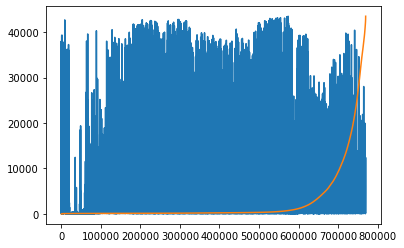

In [3]:
y_arr = np.sort(y)
plt.plot(y)
plt.plot(y_arr)

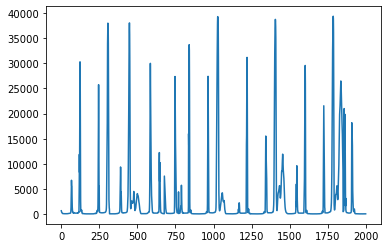

In [4]:
plt.plot(y[0:2000])

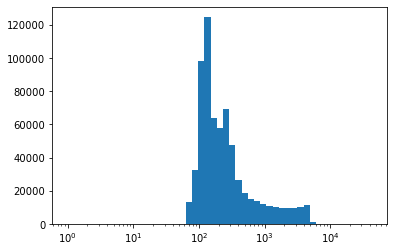

In [35]:
Y = np.array(y)
bins = np.logspace(np.log10(1),np.log10(max(y)))

plt.hist(Y[Y <= 5000], bins=bins)
plt.xscale('log')

In [6]:
coze = np.array(X).reshape(len(X),10,1)
X_train, X_test, y_train, y_test = train_test_split(coze, y, random_state=420)

In [36]:
np.shape(X_test[0])

(10, 1)

In [42]:
model = Sequential()
model.add(Input(10))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1,activation='relu'))

model.compile(optimizer=Adam(learning_rate=0.01),
              loss="mean_squared_error")

conv_callback = [EarlyStopping(monitor='val_loss', patience=5)]
#TensorBoard(log_dir = "./logs/conv/{}-{}-{}-{}".format(datetime.datetime.today().month,datetime.datetime.today().day,datetime.datetime.today().hour,datetime.datetime.today().minute), update_freq="epoch"
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 100)               1100      
                                                                 
 dense_32 (Dense)            (None, 50)                5050      
                                                                 
 dense_33 (Dense)            (None, 25)                1275      
                                                                 
 dense_34 (Dense)            (None, 5)                 130       
                                                                 
 dense_35 (Dense)            (None, 1)                 6         
                                                                 
Total params: 7,561
Trainable params: 7,561
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(np.array(X_train), np.array(y_train),
          validation_data = (np.array(X_test), np.array(y_test)),
          batch_size=512, epochs=100, callbacks=[conv_callback])

Epoch 1/100
1128/1128 [==============================] - 3s 3ms/step - loss: 167307520.0000 - val_loss: 51784992.0000
Epoch 2/100
1128/1128 [==============================] - 3s 2ms/step - loss: 51362120.0000 - val_loss: 51784992.0000
Epoch 3/100
1128/1128 [==============================] - 3s 2ms/step - loss: 51362052.0000 - val_loss: 51784992.0000
Epoch 4/100
1128/1128 [==============================] - 3s 3ms/step - loss: 51362092.0000 - val_loss: 51784992.0000
Epoch 5/100
1128/1128 [==============================] - 3s 3ms/step - loss: 51362084.0000 - val_loss: 51784992.0000
Epoch 6/100
1128/1128 [==============================] - 3s 3ms/step - loss: 51362076.0000 - val_loss: 51784992.0000


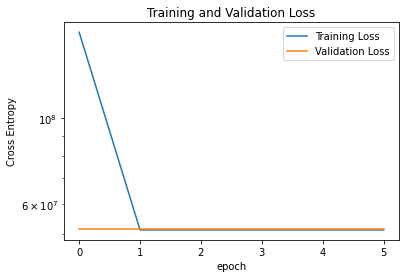

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.yscale("log")
plt.show()

In [10]:
X_test[0]

array([[2.45947846e+06],
       [2.45947846e+06],
       [8.84593000e+00],
       [5.19746000e+01],
       [5.68609000e+02],
       [8.82027000e+00],
       [5.19135000e+01],
       [5.68607000e+02],
       [0.00000000e+00],
       [0.00000000e+00]])

In [11]:
que = np.reshape(X_test[0],(1,10,1))
print(que)
X_test_re = np.zeros_like(X_test)
for i in range(len(X_test)):
    X_test_re[i] = np.reshape(X_test[i],(1,10,1))

[[[2.45947846e+06]
  [2.45947846e+06]
  [8.84593000e+00]
  [5.19746000e+01]
  [5.68609000e+02]
  [8.82027000e+00]
  [5.19135000e+01]
  [5.68607000e+02]
  [0.00000000e+00]
  [0.00000000e+00]]]


In [48]:
print(X_test[0])
print(X_test_re[0:1])

[[2.45947846e+06]
 [2.45947846e+06]
 [8.84593000e+00]
 [5.19746000e+01]
 [5.68609000e+02]
 [8.82027000e+00]
 [5.19135000e+01]
 [5.68607000e+02]
 [0.00000000e+00]
 [0.00000000e+00]]
[[[2.45947846e+06]
  [2.45947846e+06]
  [8.84593000e+00]
  [5.19746000e+01]
  [5.68609000e+02]
  [8.82027000e+00]
  [5.19135000e+01]
  [5.68607000e+02]
  [0.00000000e+00]
  [0.00000000e+00]]]


In [47]:
y_pred = model.predict(X_test_re[0:10])
y_pred

1/1 [==============================] - 0s 79ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [14]:
y[0:100]

[697.733,
 554.733,
 454.467,
 387.067,
 343.4,
 288.6,
 237.133,
 195.867,
 166.333,
 140.333,
 135.4,
 126.4,
 128.2,
 116.867,
 118.4,
 116.4,
 114.867,
 115.533,
 117.333,
 111.467,
 109.733,
 106.667,
 114.933,
 108.8,
 113.933,
 108.267,
 112.4,
 110.0,
 101.867,
 107.0,
 104.133,
 105.0,
 107.067,
 112.667,
 105.267,
 110.0,
 113.133,
 110.667,
 119.333,
 118.6,
 119.067,
 118.4,
 119.467,
 124.333,
 123.333,
 127.667,
 133.933,
 135.467,
 144.6,
 147.4,
 150.6,
 159.6,
 172.2,
 174.933,
 178.733,
 187.933,
 194.933,
 201.733,
 209.467,
 224.933,
 225.533,
 251.133,
 321.133,
 668.0,
 1408.13,
 3167.4,
 5223.27,
 6756.4,
 5719.67,
 5568.93,
 4374.73,
 2049.87,
 1407.07,
 975.733,
 525.6,
 468.2,
 350.8,
 276.8,
 259.533,
 277.667,
 282.8,
 369.467,
 310.2,
 244.733,
 241.533,
 239.2,
 226.533,
 227.6,
 225.8,
 229.2,
 228.933,
 236.067,
 226.467,
 227.333,
 230.6,
 226.733,
 224.333,
 223.333,
 223.867,
 240.467]

In [15]:
print(len(y_pred))
print(len(X_test_re))

1
192393


In [16]:
print(np.shape(y_pred))
print(np.shape(X_test_re))

(1, 1)
(192393, 10, 1)


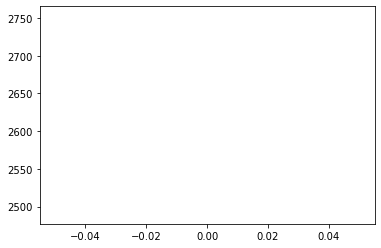

In [17]:
plt.plot(y_pred)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: object too deep for desired array

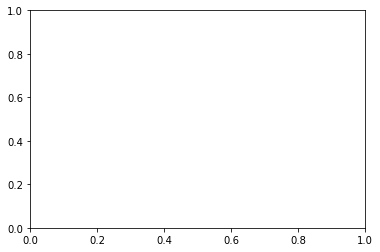

In [18]:

plt.hist2d(y_pred.reshape(-1), y_test[0], bins=30);

In [ ]:
            trig_start.append(t.jd[0])
            trig_end.append(t.jd[1])
            lon_start.append(float(split[7]))
            lat_start.append(float(split[8]))
            alt_start.append(float(split[9]))
            lon_end.append(float(split[10]))
            lat_end.append(float(split[11]))
            alt_end.append(float(split[12]))
            temp1.append(float(split[16]))
            temp2.append(float(split[17]))
            cnt.append(float(split[-2]))

df["trig_start"] = trig_start
df["trig_end"] = trig_end
df["lon_start"] = lon_start
df["lat_start"] = lat_start
df["alt_start"] = alt_start
df["lon_end"] = lon_end
df["lat_end"] = lat_end
df["alt_end"] = alt_end
df["temp1"] = temp1
df["temp2"] = temp2
df["cnt"] = cnt

In [21]:
cols = ["trig_start", "trig_end",
        "lon_start", "lon_end",
        "lat_start", "lat_end",
        "alt_start", "alt_end",
        "temp1", "temp2"]
df = pd.DataFrame(data = X, columns=cols)



In [22]:
df

,trig_start,trig_end,lon_start,lon_end,lat_start,lat_end,alt_start,alt_end,temp1,temp2
0,2.459325e+06,2.459325e+06,325.5510,-6.10076,566.955,325.3640,-5.16652,566.652,1.56250,1.46875
1,2.459325e+06,2.459325e+06,325.3640,-5.16652,566.652,325.1770,-4.23216,566.354,1.59375,1.53125
2,2.459325e+06,2.459325e+06,325.1770,-4.23216,566.354,324.9910,-3.29768,566.063,1.59375,1.59375
3,2.459325e+06,2.459325e+06,324.9910,-3.29768,566.063,324.8040,-2.36310,565.777,1.62500,1.62500
4,2.459325e+06,2.459325e+06,324.8040,-2.36310,565.777,324.6180,-1.42841,565.497,1.62500,1.62500
...,...,...,...,...,...,...,...,...,...,...
769567,2.459893e+06,2.459893e+06,82.9377,-54.15430,571.556,82.9098,-54.21510,571.569,1.31000,1.94000
769568,2.459893e+06,2.459893e+06,82.9098,-54.21510,571.569,82.8819,-54.27590,571.582,1.31000,1.94000
769569,2.459893e+06,2.459893e+06,82.8819,-54.27590,571.582,82.8539,-54.33680,571.595,1.31000,1.94000
769570,2.459893e+06,2.459893e+06,82.8539,-54.33680,571.595,82.8258,-54.39760,571.608,1.31000,1.94000


In [24]:
df.describe()

,trig_start,trig_end,lon_start,lon_end,lat_start,lat_end,alt_start,alt_end,temp1,temp2
count,7.695720e+05,7.695720e+05,769572.000000,769572.000000,769572.000000,769572.000000,769572.000000,769572.000000,769572.000000,769572.000000
mean,2.459757e+06,2.459757e+06,179.856198,0.950825,554.877797,179.879841,0.942560,554.878732,7.259540,7.362515
std,1.653955e+02,1.653955e+02,106.948894,49.474535,11.926570,106.940155,49.475627,11.927437,7.075973,6.968994
min,2.459322e+06,2.459322e+06,0.000003,-82.527000,527.375000,0.000003,-82.527000,527.375000,-2.437500,-2.156250
25%,2.459807e+06,2.459807e+06,88.479750,-41.396300,546.315000,88.516650,-41.407900,546.314000,1.560000,1.840000
50%,2.459821e+06,2.459821e+06,180.163000,2.305175,554.846000,180.182000,2.294760,554.847000,6.190000,6.380000
75%,2.459848e+06,2.459848e+06,272.084250,42.858050,563.107000,272.103000,42.850350,563.108000,12.500000,12.720000
max,2.459893e+06,2.459893e+06,360.000000,82.527200,594.025000,360.000000,82.527200,594.025000,256.000000,256.000000
